<a href="https://colab.research.google.com/github/danort92/Newspaper_classification/blob/main/Newspaper_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#basics
import pandas as pd
import numpy as np
import pickle

#nlp
import spacy
import string
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords

#viz
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.utils import resample
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

#imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

#keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, TimeDistributed, Flatten, Dropout
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import Precision, Recall


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# IMPORTING DATAFRAME

There are two dataframe, one in english and one in japanese. They will be analyzed separately

In [3]:
url_eng="https://media.githubusercontent.com/media/danort92/Newspaper_classification/main/news/english_news.csv"
df_eng = pd.read_csv(url_eng, sep='\t', header=0)

In [4]:
df_eng.head(10)

,source,date,title,author,text
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public..."
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was..."
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...
5,Mainichi Shimbun,2021-12-09,News Navigator: What is 'Olympic diplomacy'?,NaN,The Mainichi Shimbun answers some common quest...
6,Mainichi Shimbun,2021-12-09,Editorial: Japan's main opposition CDP has tur...,NaN,"During party leaders' questions, which began a..."
7,Mainichi Shimbun,2021-12-10,News Navigator: How does the Japanese-develope...,NaN,The Mainichi Shimbun answers some common quest...
8,Mainichi Shimbun,2021-12-10,Editorial: Japan PM's response weak on 1 mil. ...,NaN,Calls have arisen for a review of a 1 million ...
9,Mainichi Shimbun,2021-12-11,Edging Toward Japan: Inspiration from Anpan Ma...,By,"Recently, my 9-year-old daughter mentioned in ..."


In [5]:
url_jpn="https://media.githubusercontent.com/media/danort92/Newspaper_classification/main/news/japanese_news.csv"
df_jpn = pd.read_csv(url_jpn,sep='\t', header=0)

In [6]:
df_jpn.head(10)

,source,date,title,author,text
0,kobe-np.co.jp,2005-07-01,NaN,NaN,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...
1,kobe-np.co.jp,2005-07-01,NaN,NaN,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...
2,kobe-np.co.jp,2007-04-07,NaN,NaN,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...
3,kobe-np.co.jp,2007-04-07,NaN,NaN,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。
4,kobe-np.co.jp,2007-04-07,NaN,NaN,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...
5,kobe-np.co.jp,2007-04-07,NaN,NaN,弁護側によると、四人の被告のうち、金沢被告は上告する意思を示しているという。（川口洋光、大月美佳）
6,kobe-np.co.jp,2007-04-07,NaN,NaN,「われわれの苦しみと悲しみは一生消えない」。ずさんな警備で多数の死傷者が出た明石・歩道橋事故...
7,kobe-np.co.jp,2007-04-07,NaN,NaN,この日、裁判長は「被告以外に過失責任を問われる余地がある者もいる」として、被告以外の関係者の...
8,hokkaido-np.co.jp,2007-04-28,NaN,NaN,とても心配です。最下位に低迷している日本ハムに「またか、どうしたの！」と言いながら、少しずつ...
9,hokkaido-np.co.jp,2007-04-28,NaN,NaN,■反省 離れていく心が心配


# PREPROCESSING:

The first step, after importing the dataframe is to 1) analyse them and 2) clean them removing NaN values, stopwords and punctuation that don't give added value. The preprocessing is performed on eng and jpn dataframe separately (obviously for language reasons), new cleaned dataframe are saved and then merged.

In [7]:
def get_news_plot(df):

  """
  function that plots the number of news per newspaper

  INPUT - df:pandas dataframe

  OUTPUT - classes frequency plot
  """

  counter=df.groupby("source")["text"].count()
  x=counter.to_dict().values()
  y=counter.to_dict().keys()

  fig = plt.figure(figsize=(12,10))
  plt.xticks(rotation=60, ha="center")
  plt.title("News from newspapers")
  plt.ylabel('Number of news', fontsize=12)
  plt.xlabel('Newspapers name', fontsize=12)

  plt.bar(y,x,width=0.5,alpha=0.7);

In [8]:
def data_cleaner(df, language="english"):

  """
  function that cleans news' text from stopwords and punctuation

  INPUT - df: dataframe
        - language: str, language of news' text

  OUTPUT: - df_to_return: cleaned dataframe

  """
  nltk.download("stopwords")

  if language=="english":
    sw=stopwords.words(language)
    nlp=spacy.load("en_core_web_sm")
  if language=="japanese":
    !python -m spacy download ja_core_news_sm
    nlp=spacy.load("ja_core_news_sm")

  punctuation=set(string.punctuation)
  up_ele = ["・","、" , "。"]
  punctuation |= set(up_ele)

  df_to_return=[]
  for sentence in df:
      #transform sentence in lower case and replace punctuation with space
      sentence=sentence.lower()
      for c in string.punctuation:
          sentence=sentence.replace(c," ")

      #trasform sentence in lemmatized tokens using nlp variable previously inizialized
      document=nlp(sentence)
      sentence=" ".join(token.lemma_ for token in document)

      #remove english stopwords, removing numbers and redundant spaces
      if language=="english":
        sentence=" ".join(word for word in sentence.split() if word not in sw)
      else:
        sentence=" ".join(word for word in sentence.split())
      sentence=re.sub("\d","", sentence)
      sentence=re.sub(" +"," ", sentence)
      df_to_return.append(sentence)

  return df_to_return

In [9]:
def resample_df(df, n_max, n_sample):

  """
  function that resamples a dataframe

  INPUT - df: dataframe
        - n_max: max number of class recurrences, if higher class is resampled
        - n_sample: value at which classes are resampled

  OUTPUT: - df_resampled: resampled dataframe

  """

  counter=dict(df.groupby("source")["text"].count())
  to_resample={(k, v) for k, v in counter.items() if v >= n_max}
  not_to_resample={(k, v) for k, v in counter.items() if v < n_max}
  to_resample_keys=list(dict(to_resample).keys())
  not_to_resample_keys=list(dict(not_to_resample).keys())

  df_to_resample=[]
  df_not_to_resample=[]
  df_to_resample = pd.DataFrame(df_to_resample)
  df_not_to_resample = pd.DataFrame(df_not_to_resample)

  for i in range(len(to_resample_keys)):
    df_i=df[df["source"]==to_resample_keys[i]]
    df_to_resample=pd.concat([df_to_resample,df_i])
  for j in range(len(not_to_resample_keys)):
    df_j=df[df["source"]==not_to_resample_keys[j]]
    df_not_to_resample=pd.concat([df_not_to_resample,df_j])

  #resampling because of RAM limitation of Google Colab (just on the classes with higher than 5000 occurrences)
  df_to_resample.sample(frac=1).reset_index(drop=True)
  df_to_resample=df_to_resample.groupby("source").apply(lambda x: x.sample(n_sample, replace=True)).droplevel(0)
  df_resampled=pd.concat([df_to_resample,df_not_to_resample])

  return df_resampled

In [10]:
df_eng["source"].value_counts()

The Japan Times     36815
Mainichi Shimbun       74
Name: source, dtype: int64

In [11]:
df_eng=df_eng[["source","text"]]
df_eng.head(10)

,source,text
0,Mainichi Shimbun,The Japanese government is trying to boost the...
1,Mainichi Shimbun,"Prime Minister Fumio Kishida, who won a public..."
2,Mainichi Shimbun,It has been 80 years since the start of the Pa...
3,Mainichi Shimbun,"""The world has changed completely. The era was..."
4,Mainichi Shimbun,The U.S. administration under President Joe Bi...
5,Mainichi Shimbun,The Mainichi Shimbun answers some common quest...
6,Mainichi Shimbun,"During party leaders' questions, which began a..."
7,Mainichi Shimbun,The Mainichi Shimbun answers some common quest...
8,Mainichi Shimbun,Calls have arisen for a review of a 1 million ...
9,Mainichi Shimbun,"Recently, my 9-year-old daughter mentioned in ..."


In [12]:
df_eng.groupby("source").text.apply(lambda x: x.isna().sum())

source
Mainichi Shimbun      0
The Japan Times     123
Name: text, dtype: int64

In [13]:
df_eng=df_eng.dropna()

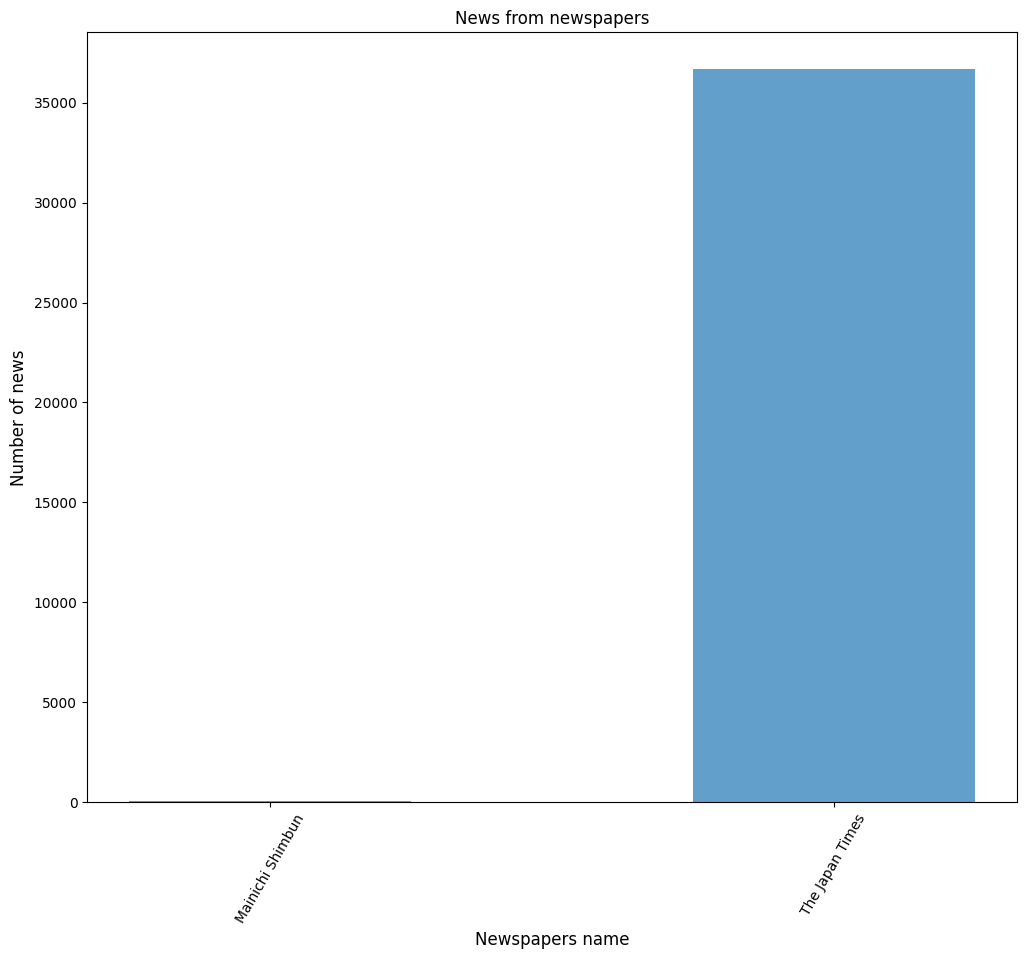

In [14]:
get_news_plot(df_eng)

In [15]:
df_jpn["source"].value_counts()

mainichi.jp          44657
sankei.jp.msn.com    35959
nikkei.com           29323
sanspo.com           26303
tomamin.co.jp        26054
nikkansports.com     25483
oita-press.co.jp     23645
yomiuri.co.jp        22472
nishinippon.co.jp    21311
asahi.com            19855
hokkaido-np.co.jp    10653
shimotsuke.co.jp      9581
kobe-np.co.jp         8311
kyoto-np.co.jp        3408
yamagata-np.jp        2585
isenp.co.jp           1496
iwate-np.co.jp        1198
nnn.co.jp              347
tokachi.co.jp          176
chunichi.co.jp          73
tokyo-np.co.jp          65
Name: source, dtype: int64

In [16]:
df_jpn=df_jpn[["source","text"]]
df_jpn.head(10)

,source,text
0,kobe-np.co.jp,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...
1,kobe-np.co.jp,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...
2,kobe-np.co.jp,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...
3,kobe-np.co.jp,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。
4,kobe-np.co.jp,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...
5,kobe-np.co.jp,弁護側によると、四人の被告のうち、金沢被告は上告する意思を示しているという。（川口洋光、大月美佳）
6,kobe-np.co.jp,「われわれの苦しみと悲しみは一生消えない」。ずさんな警備で多数の死傷者が出た明石・歩道橋事故...
7,kobe-np.co.jp,この日、裁判長は「被告以外に過失責任を問われる余地がある者もいる」として、被告以外の関係者の...
8,hokkaido-np.co.jp,とても心配です。最下位に低迷している日本ハムに「またか、どうしたの！」と言いながら、少しずつ...
9,hokkaido-np.co.jp,■反省 離れていく心が心配


In [17]:
df_jpn.groupby("source").text.apply(lambda x: x.isna().sum())

source
asahi.com            0
chunichi.co.jp       0
hokkaido-np.co.jp    0
isenp.co.jp          0
iwate-np.co.jp       0
kobe-np.co.jp        0
kyoto-np.co.jp       0
mainichi.jp          1
nikkansports.com     0
nikkei.com           0
nishinippon.co.jp    0
nnn.co.jp            0
oita-press.co.jp     0
sankei.jp.msn.com    0
sanspo.com           0
shimotsuke.co.jp     0
tokachi.co.jp        0
tokyo-np.co.jp       0
tomamin.co.jp        0
yamagata-np.jp       0
yomiuri.co.jp        0
Name: text, dtype: int64

In [18]:
df_jpn=df_jpn.dropna()

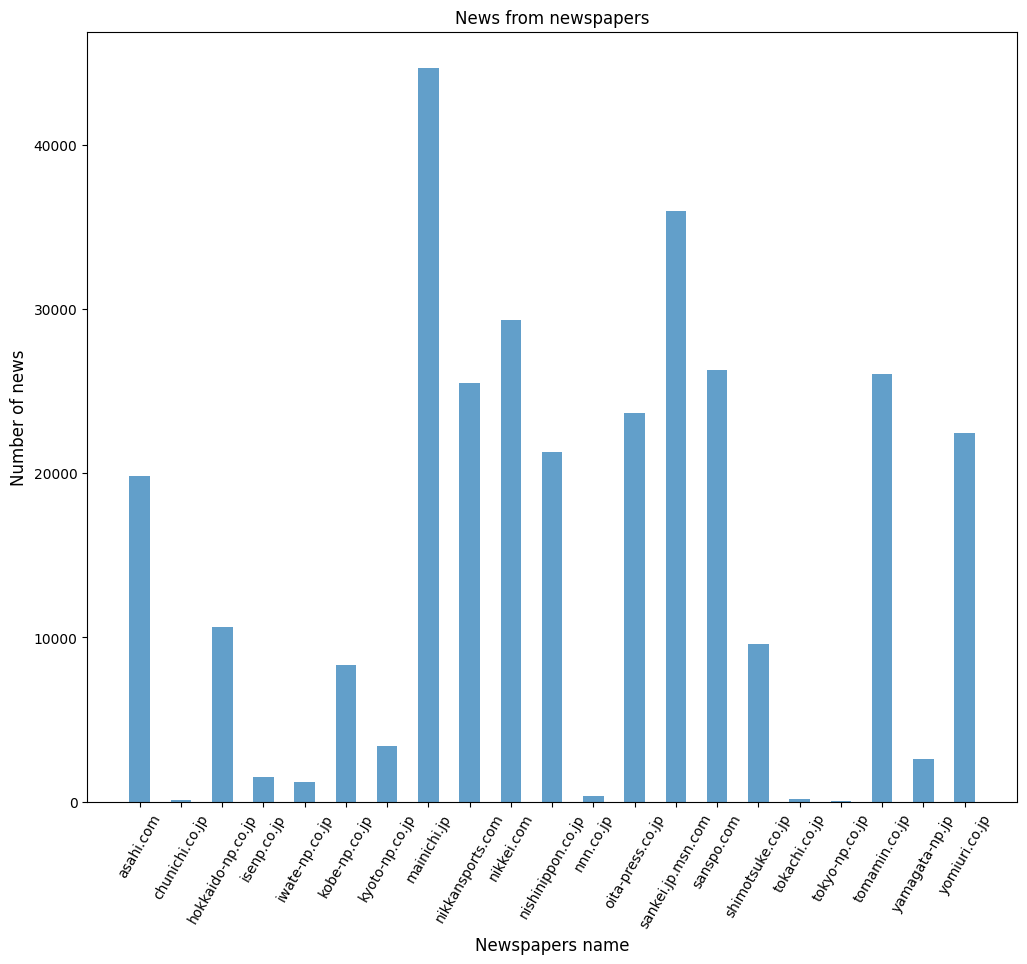

In [19]:
get_news_plot(df_jpn)

In [20]:
#text_eng_cleaned = data_cleaner(df_eng["text"], language="english")

In [21]:
#df_eng_cleaned = pd.DataFrame(data={"source": list(df_eng["source"]),
#                                    "text": text_eng_cleaned})
#df_eng_cleaned.to_csv("english_news_cleaned.csv", index=False)

#from google.colab import files
#files.download("english_news_cleaned.csv")

In [22]:
#text_jpn_cleaned = data_cleaner(df_jpn["text"], language="japanese")

In [23]:
#df_jpn_cleaned = pd.DataFrame(data={"source": list(df_jpn["source"]),
                                    #"text": text_jpn_cleaned})
#df_jpn_cleaned.to_csv("japanese_news_cleaned.csv", index=False)

#from google.colab import files
#files.download("japanese_news_cleaned.csv")

## SAVING MODEL:

 Cleaned dataframe have been saved in Github to have them ready-to-use avoiding the preprocessing at every code run and are now reloaded and merged into the total dataframe

In [24]:
url_eng_cleaned="https://media.githubusercontent.com/media/danort92/Newspaper_classification/main/news/english_news_cleaned.csv"
df_eng_cleaned = pd.read_csv(url_eng_cleaned, sep=',', header=0)
df_eng_cleaned.head(10)

,source,text
0,Mainichi Shimbun,japanese government try boost uptake number pe...
1,Mainichi Shimbun,prime minister fumio kishida win public mandat...
2,Mainichi Shimbun,year since start pacific war imperial japanes...
3,Mainichi Shimbun,world change completely era enormously sever c...
4,Mainichi Shimbun,u administration president joe biden decide di...
5,Mainichi Shimbun,mainichi shimbun answer common question reader...
6,Mainichi Shimbun,party leader question begin plenary session ho...
7,Mainichi Shimbun,mainichi shimbun answer common question reader...
8,Mainichi Shimbun,call arise review million yen per month corres...
9,Mainichi Shimbun,recently year old daughter mention kitchen hom...


In [25]:
df_eng_cleaned["source"].value_counts()

The Japan Times     36692
Mainichi Shimbun       74
Name: source, dtype: int64

In [26]:
url_jpn_cleaned="https://media.githubusercontent.com/media/danort92/Newspaper_classification/main/news/japanese_news_cleaned.csv"
df_jpn_cleaned = pd.read_csv(url_jpn_cleaned, sep=',', header=0)
df_jpn_cleaned.head(10)

,source,text
0,kobe-np.co.jp,会見 する た 北口 寛人 市長 は 「 刑事 訴訟 で 被告 と なる て いる 職員 に...
1,kobe-np.co.jp,明石 ・ 歩道 橋 事故 を めぐる 民事 訴訟 で 、 神戸 地裁 から 計 五億六千八百...
2,kobe-np.co.jp,会見 後 、 遺族 代理 人 の 渡部 吉泰 弁護 士 は 「 裁判 長 が 『 問う べし...
3,kobe-np.co.jp,遺族 会 は 、 雑踏 警備 本部 長 を 務める た 元 明石 署 長 ら 二人 の 起訴...
4,kobe-np.co.jp,五 人 の 遺族 が 閉廷 後 に 会見 。 二女 の 優衣菜 ちゃん = 当時 ( つ )...
5,kobe-np.co.jp,弁護 側 に よる と 、 四 人 の 被告 の うち 、 金沢 被告 は 上告 する 意思...
6,kobe-np.co.jp,「 われわれ の 苦しい み と 悲しい み は 一生 消える ない 」 。 ずさん だ 警...
7,kobe-np.co.jp,この 日 、 裁判 長 は 「 被告 以外 に 過失 責任 を 問う れる 余地 が ある ...
8,hokkaido-np.co.jp,とても 心配 です 。 最 下位 に 低迷 する て いる 日本 ハム に 「 また か 、...
9,hokkaido-np.co.jp,■ 反省 離れる て いく 心 が 心配


In [27]:
df_jpn_cleaned["source"].value_counts()

mainichi.jp          44656
sankei.jp.msn.com    35959
nikkei.com           29323
sanspo.com           26303
tomamin.co.jp        26054
nikkansports.com     25483
oita-press.co.jp     23645
yomiuri.co.jp        22472
nishinippon.co.jp    21311
asahi.com            19855
hokkaido-np.co.jp    10653
shimotsuke.co.jp      9581
kobe-np.co.jp         8311
kyoto-np.co.jp        3408
yamagata-np.jp        2585
isenp.co.jp           1496
iwate-np.co.jp        1198
nnn.co.jp              347
tokachi.co.jp          176
chunichi.co.jp          73
tokyo-np.co.jp          65
Name: source, dtype: int64

In [28]:
df=pd.concat([df_eng_cleaned,df_jpn_cleaned])
df=df.dropna()

In [29]:
df.groupby("source").text.apply(lambda x: x.isna().sum())

source
Mainichi Shimbun     0
The Japan Times      0
asahi.com            0
chunichi.co.jp       0
hokkaido-np.co.jp    0
isenp.co.jp          0
iwate-np.co.jp       0
kobe-np.co.jp        0
kyoto-np.co.jp       0
mainichi.jp          0
nikkansports.com     0
nikkei.com           0
nishinippon.co.jp    0
nnn.co.jp            0
oita-press.co.jp     0
sankei.jp.msn.com    0
sanspo.com           0
shimotsuke.co.jp     0
tokachi.co.jp        0
tokyo-np.co.jp       0
tomamin.co.jp        0
yamagata-np.jp       0
yomiuri.co.jp        0
Name: text, dtype: int64

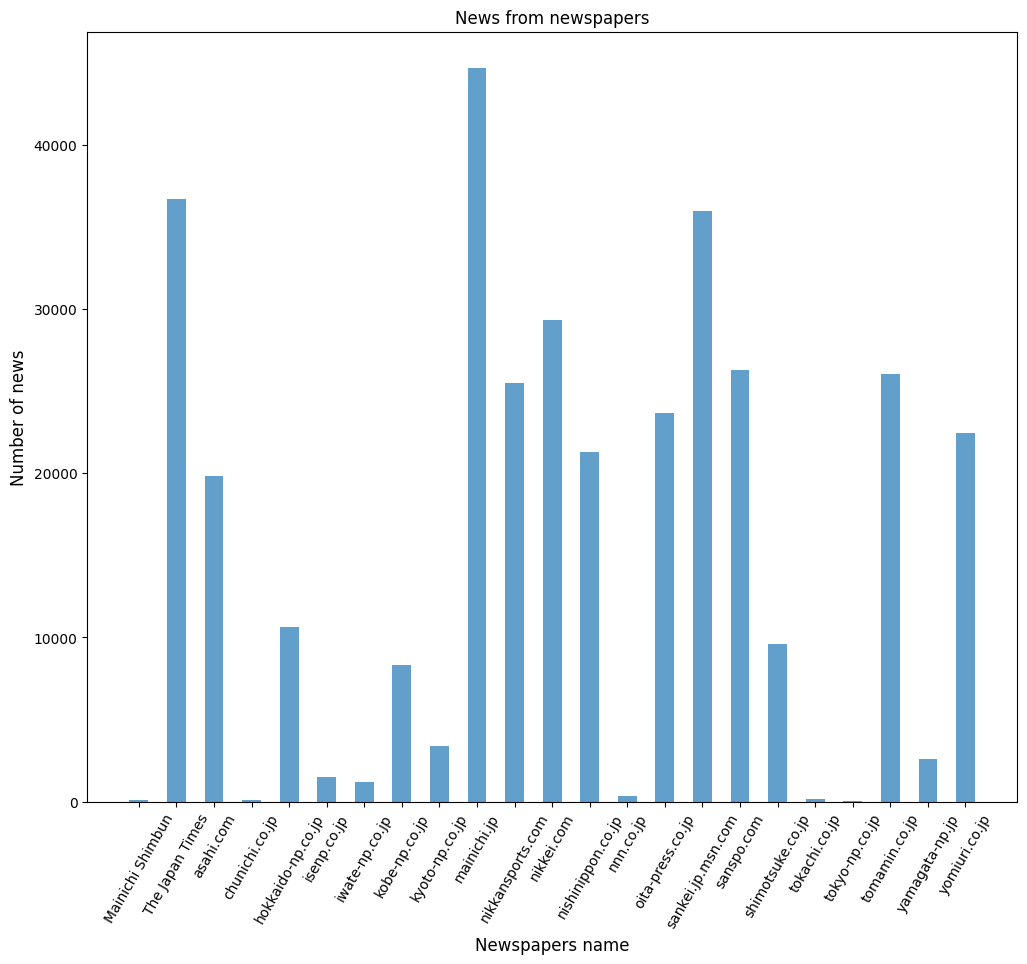

In [30]:
get_news_plot(df)

In [31]:
df=resample_df(df,n_max=5000,n_sample=8000)

In [32]:
df["source"].value_counts()

The Japan Times      8000
oita-press.co.jp     8000
yomiuri.co.jp        8000
tomamin.co.jp        8000
asahi.com            8000
sanspo.com           8000
sankei.jp.msn.com    8000
shimotsuke.co.jp     8000
nishinippon.co.jp    8000
nikkei.com           8000
nikkansports.com     8000
mainichi.jp          8000
kobe-np.co.jp        8000
hokkaido-np.co.jp    8000
kyoto-np.co.jp       3408
yamagata-np.jp       2585
isenp.co.jp          1496
iwate-np.co.jp       1198
nnn.co.jp             347
tokachi.co.jp         176
Mainichi Shimbun       74
chunichi.co.jp         73
tokyo-np.co.jp         65
Name: source, dtype: int64

# MODELLING:

We try different models both with sklearn and keras and plot the confusion matrix and the classification report to analyse the *metrics*

## FUNCTIONS

In [33]:
def bow_tfidf(dataset,tfidf_vectorizer, max_features=1000):

  """
  function that vectorize the features

  INPUT: - dataset; pandas dataframe
         - tfidf_vectorizer; if None fit and transform are performed (for train), otherwise only transform (for test)
         - max_features; max amount of features - default 1000

  OUTPUT: - X.toarray(); vectorized array of features
          - tfidf_vectorizer; vectorize instance to be used for test features
  """

    if tfidf_vectorizer==None:
        tfidf_vectorizer=TfidfVectorizer(max_features=max_features)
        X=tfidf_vectorizer.fit_transform(dataset)
    else:
        X=tfidf_vectorizer.transform(dataset)
    return X.toarray(), tfidf_vectorizer

In [34]:
def plot_confusion_matrix(X_test,y_test,y_pred):

  """
  function that shows a more intuitive confusion matrix

  INPUT: - X_test; test features
         - y_test; test classes
         - y_pred; predicted classes

  OUTPUT: - confusion matrix plot
  """

  conf_mat = confusion_matrix(y_test, y_pred)

  counter=df.groupby("source")["text"].count()
  y=counter.to_dict().keys()

  fig, ax = plt.subplots(figsize=(15,15))
  sns.heatmap(conf_mat, annot=True, fmt='d',
              xticklabels=y, yticklabels=y)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

In [35]:
def plot_metrics(hist):

  """
  function that show metric plots

  INPUT: - hist; history of keras models

  OUTPUT: - metric plots
  """
  plt.figure(figsize=(12,4))
  plt.subplot(1,4,1)
  plt.plot(hist.history["precision"],label="precision")
  plt.plot(hist.history["val_precision"],label="val_precision")
  plt.legend()
  plt.subplot(1,4,2)
  plt.plot(hist.history["recall"],label="recall")
  plt.plot(hist.history["val_recall"],label="val_recall")
  plt.legend()
  plt.subplot(1,4,3)
  plt.plot(hist.history["Accuracy"],label="Accuracy")
  plt.plot(hist.history["val_Accuracy"],label="val_Accuracy")
  plt.legend();
  plt.subplot(1,4,4)
  plt.plot(hist.history["loss"],label="loss")
  plt.plot(hist.history["val_loss"],label="val_loss")
  plt.legend();

In [36]:
def keras_preprocessing(X_train,X_test,y_train,y_test, num_words=1000):

  """
  function that tokeinze features

  INPUT: - X_train; train features
         - X_test; test features
         - y_train; train classes
         - y_test; test classes
         - num_words; max number of words to be considerd for the tokenization - default 1000
  """
  #tokenization of train and test sets
  tokenizer=Tokenizer(num_words=num_words)
  tokenizer.fit_on_texts(X_train)

  tok_X_train = tokenizer.texts_to_sequences(X_train)
  tok_X_test = tokenizer.texts_to_sequences(X_test)

  vocab_size = len(tokenizer.word_index) + 1

  #padding of train and test sets
  pad_X_train = pad_sequences(tok_X_train, maxlen=100,padding="post")
  pad_X_test = pad_sequences(tok_X_test, maxlen=100,padding="post")

  y_one_hot_train = pd.get_dummies(y_train)
  y_one_hot_test = pd.get_dummies(y_test)

  return pad_X_train, pad_X_test, y_one_hot_train, y_one_hot_test, vocab_size

## 1) SKLEARN

In [37]:
X_train,X_test,y_train,y_test=train_test_split(df["text"], df["source"], test_size=0.30, stratify=df["source"], random_state=42)

In [38]:
X_train,vectorizer=bow_tfidf(X_train,None,2000)
X_test,vectorizer=bow_tfidf(X_test,vectorizer,2000)

### OVERSAMPLING WITH SMOTE

In [39]:
smote=SMOTE()
X_sm,y_sm=smote.fit_resample(X_train,y_train)

### MLP CLASSIFIER

In [47]:
mlp=MLPClassifier(activation="tanh", solver="adam", hidden_layer_sizes=(500,), tol=0.01, random_state=42)
mlp.fit(X_sm,y_sm)
y_pred=mlp.predict(X_test)

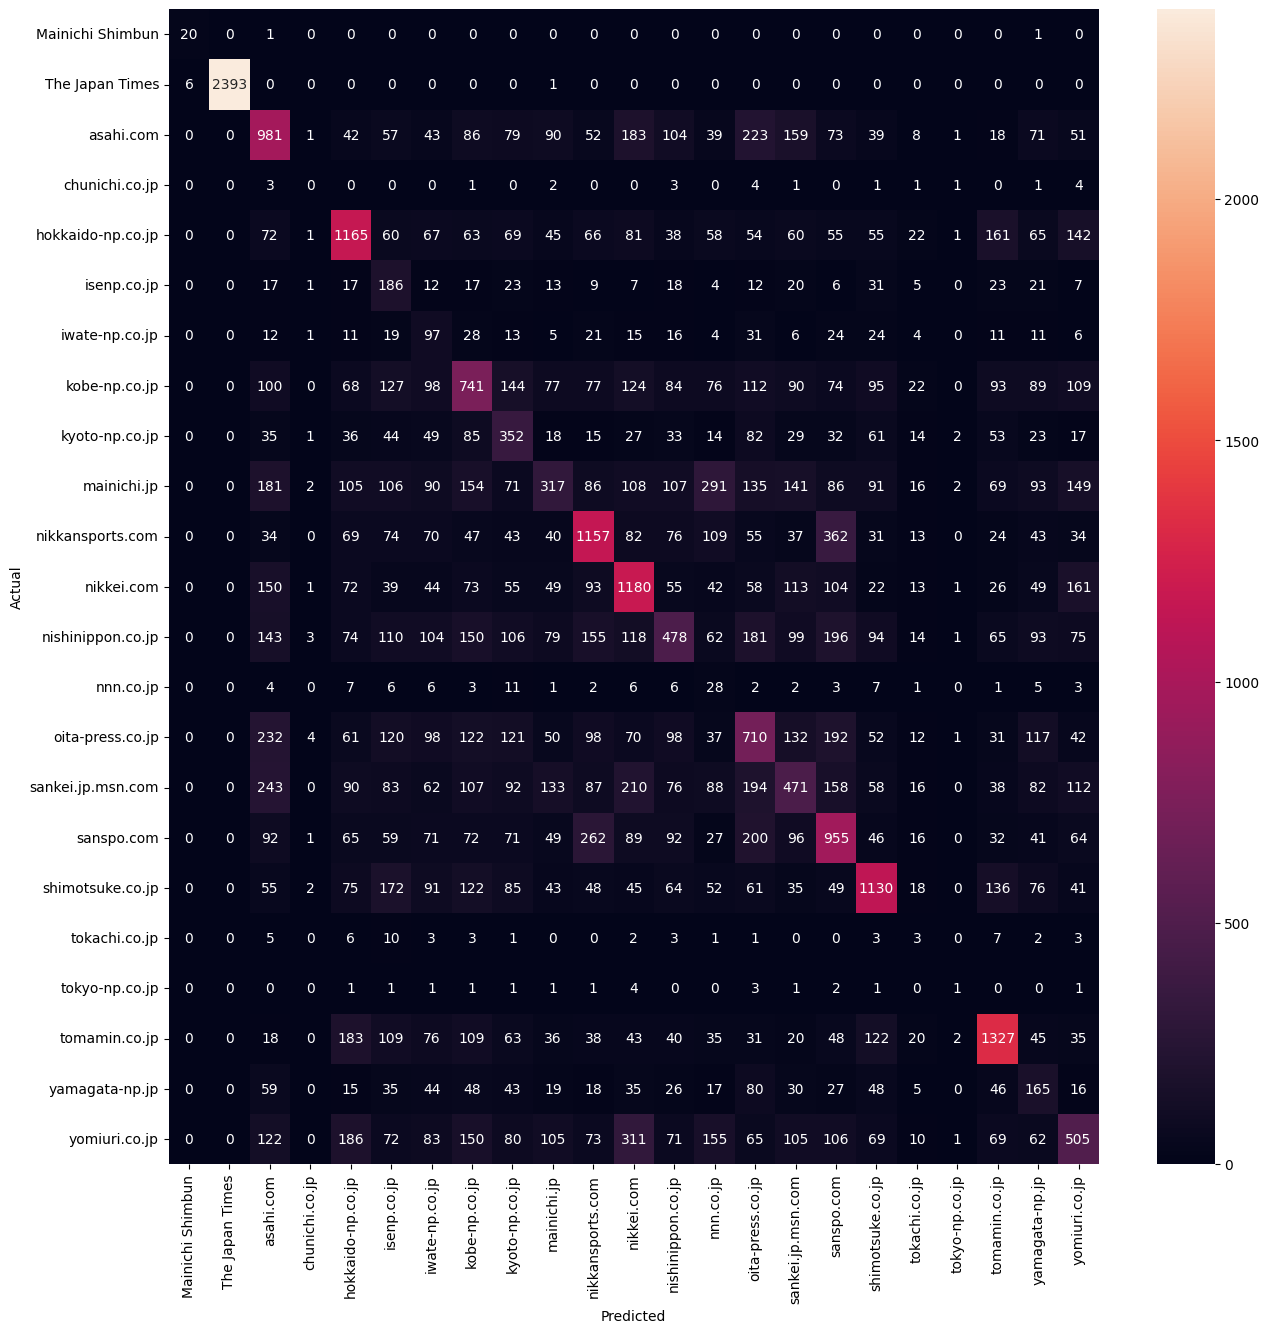

In [48]:
plot_confusion_matrix(X_test,y_test,y_pred)

In [49]:
print("TRAIN SET")
print(classification_report(y_sm,mlp.predict(X_sm),digits=4))
print("TEST SET")
print(classification_report(y_test,mlp.predict(X_test),digits=4))

TRAIN SET
                   precision    recall  f1-score   support

 Mainichi Shimbun     1.0000    1.0000    1.0000      5600
  The Japan Times     1.0000    1.0000    1.0000      5600
        asahi.com     0.4413    0.5125    0.4742      5600
   chunichi.co.jp     1.0000    0.9952    0.9976      5600
hokkaido-np.co.jp     0.5743    0.5393    0.5562      5600
      isenp.co.jp     0.5788    0.8025    0.6726      5600
   iwate-np.co.jp     0.6459    0.7389    0.6893      5600
    kobe-np.co.jp     0.4305    0.4123    0.4212      5600
   kyoto-np.co.jp     0.5327    0.5679    0.5497      5600
      mainichi.jp     0.3694    0.1964    0.2565      5600
 nikkansports.com     0.5532    0.5566    0.5549      5600
       nikkei.com     0.5027    0.5820    0.5394      5600
nishinippon.co.jp     0.4251    0.2730    0.3325      5600
        nnn.co.jp     0.7079    0.9964    0.8277      5600
 oita-press.co.jp     0.3737    0.3782    0.3760      5600
sankei.jp.msn.com     0.3702    0.2568    0.3

### SGD CLASSIFIER

In [62]:
sgd = SGDClassifier(loss='hinge', tol=0.005, random_state=42)
sgd.fit(X_sm, y_sm)
y_pred=sgd.predict(X_test)

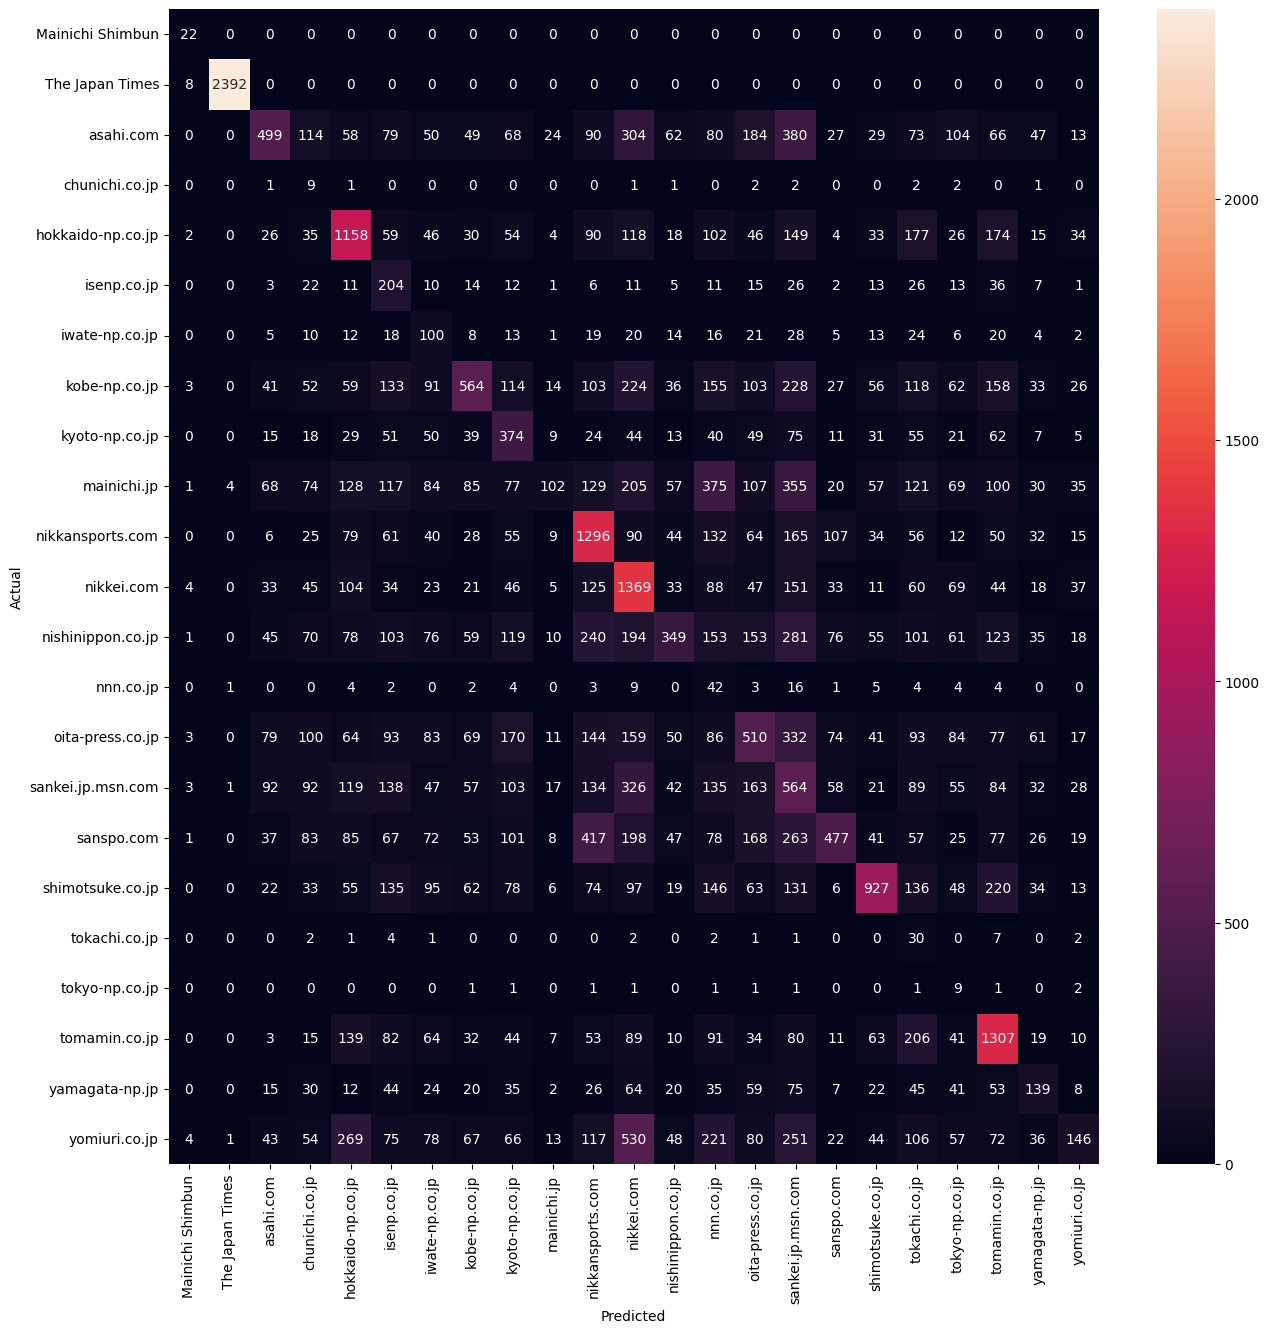

In [63]:
plot_confusion_matrix(X_test,y_test,y_pred)

In [64]:
print("TRAIN SET")
print(classification_report(y_sm,sgd.predict(X_sm),digits=4))
print("TEST SET")
print(classification_report(y_test,sgd.predict(X_test),digits=4))

TRAIN SET
                   precision    recall  f1-score   support

 Mainichi Shimbun     0.9924    1.0000    0.9962      5600
  The Japan Times     0.9986    0.9977    0.9981      5600
        asahi.com     0.5451    0.2546    0.3471      5600
   chunichi.co.jp     0.7256    0.9950    0.8392      5600
hokkaido-np.co.jp     0.5062    0.4866    0.4962      5600
      isenp.co.jp     0.5245    0.6104    0.5642      5600
   iwate-np.co.jp     0.5940    0.5150    0.5517      5600
    kobe-np.co.jp     0.4690    0.2759    0.3474      5600
   kyoto-np.co.jp     0.4657    0.4989    0.4818      5600
      mainichi.jp     0.5007    0.0632    0.1123      5600
 nikkansports.com     0.4392    0.5839    0.5013      5600
       nikkei.com     0.3542    0.6046    0.4467      5600
nishinippon.co.jp     0.4271    0.1720    0.2452      5600
        nnn.co.jp     0.4776    0.9504    0.6357      5600
 oita-press.co.jp     0.2731    0.2557    0.2641      5600
sankei.jp.msn.com     0.1523    0.3041    0.2

### LOGISTIC REGRESSION

In [43]:
lrc = LogisticRegression(solver="saga", tol=0.005, random_state=42)
lrc.fit(X_sm, y_sm)
y_pred=lrc.predict(X_test)

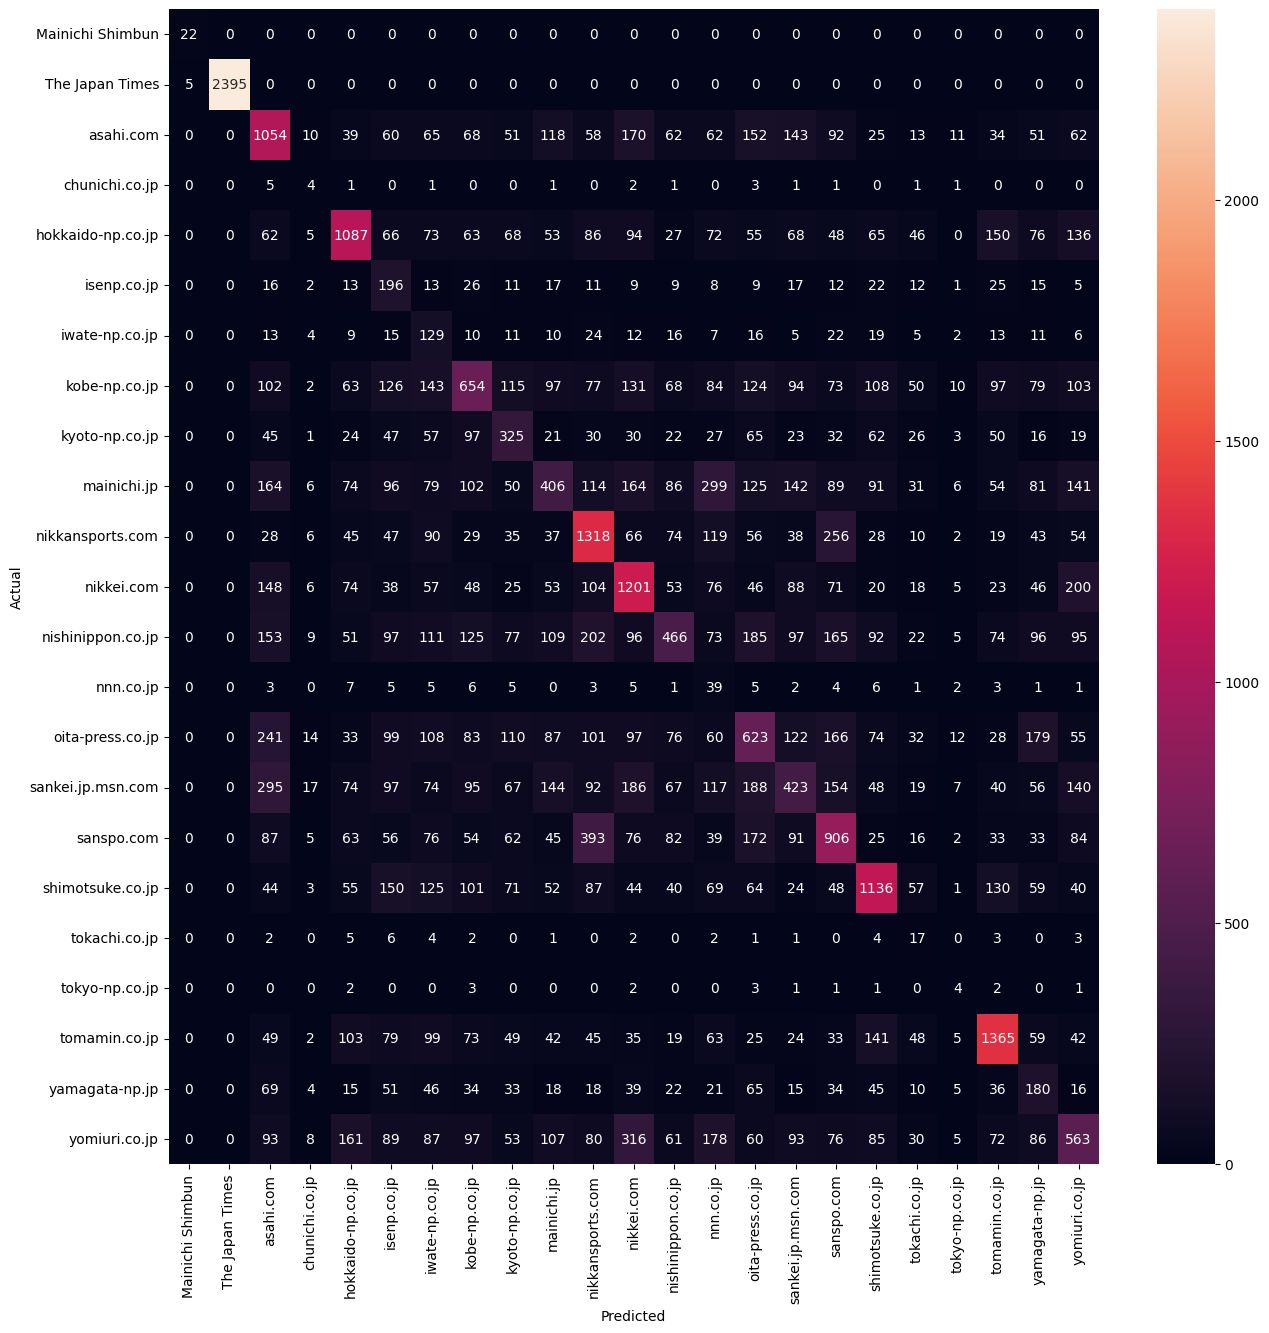

In [44]:
plot_confusion_matrix(X_test,y_test, y_pred)

In [45]:
print("TRAIN SET")
print(classification_report(y_sm,lrc.predict(X_sm),digits=4))
print("TEST SET")
print(classification_report(y_test,lrc.predict(X_test),digits=4))

TRAIN SET
                   precision    recall  f1-score   support

 Mainichi Shimbun     0.9984    1.0000    0.9992      5600
  The Japan Times     1.0000    0.9984    0.9992      5600
        asahi.com     0.4301    0.4998    0.4623      5600
   chunichi.co.jp     0.9587    0.9993    0.9786      5600
hokkaido-np.co.jp     0.5915    0.4907    0.5364      5600
      isenp.co.jp     0.5631    0.6813    0.6166      5600
   iwate-np.co.jp     0.5870    0.7011    0.6390      5600
    kobe-np.co.jp     0.4294    0.3452    0.3827      5600
   kyoto-np.co.jp     0.5580    0.4714    0.5111      5600
      mainichi.jp     0.3432    0.2175    0.2663      5600
 nikkansports.com     0.4934    0.6080    0.5448      5600
       nikkei.com     0.4662    0.5436    0.5019      5600
nishinippon.co.jp     0.4024    0.2309    0.2934      5600
        nnn.co.jp     0.5563    0.9732    0.7080      5600
 oita-press.co.jp     0.3624    0.3371    0.3493      5600
sankei.jp.msn.com     0.3402    0.2318    0.2

### RANDOM FOREST

In [48]:
rfc = RandomForestClassifier(n_estimators=200, class_weight="balanced_subsample", random_state=42)
rfc.fit(X_sm, y_sm)
y_pred=rfc.predict(X_test)

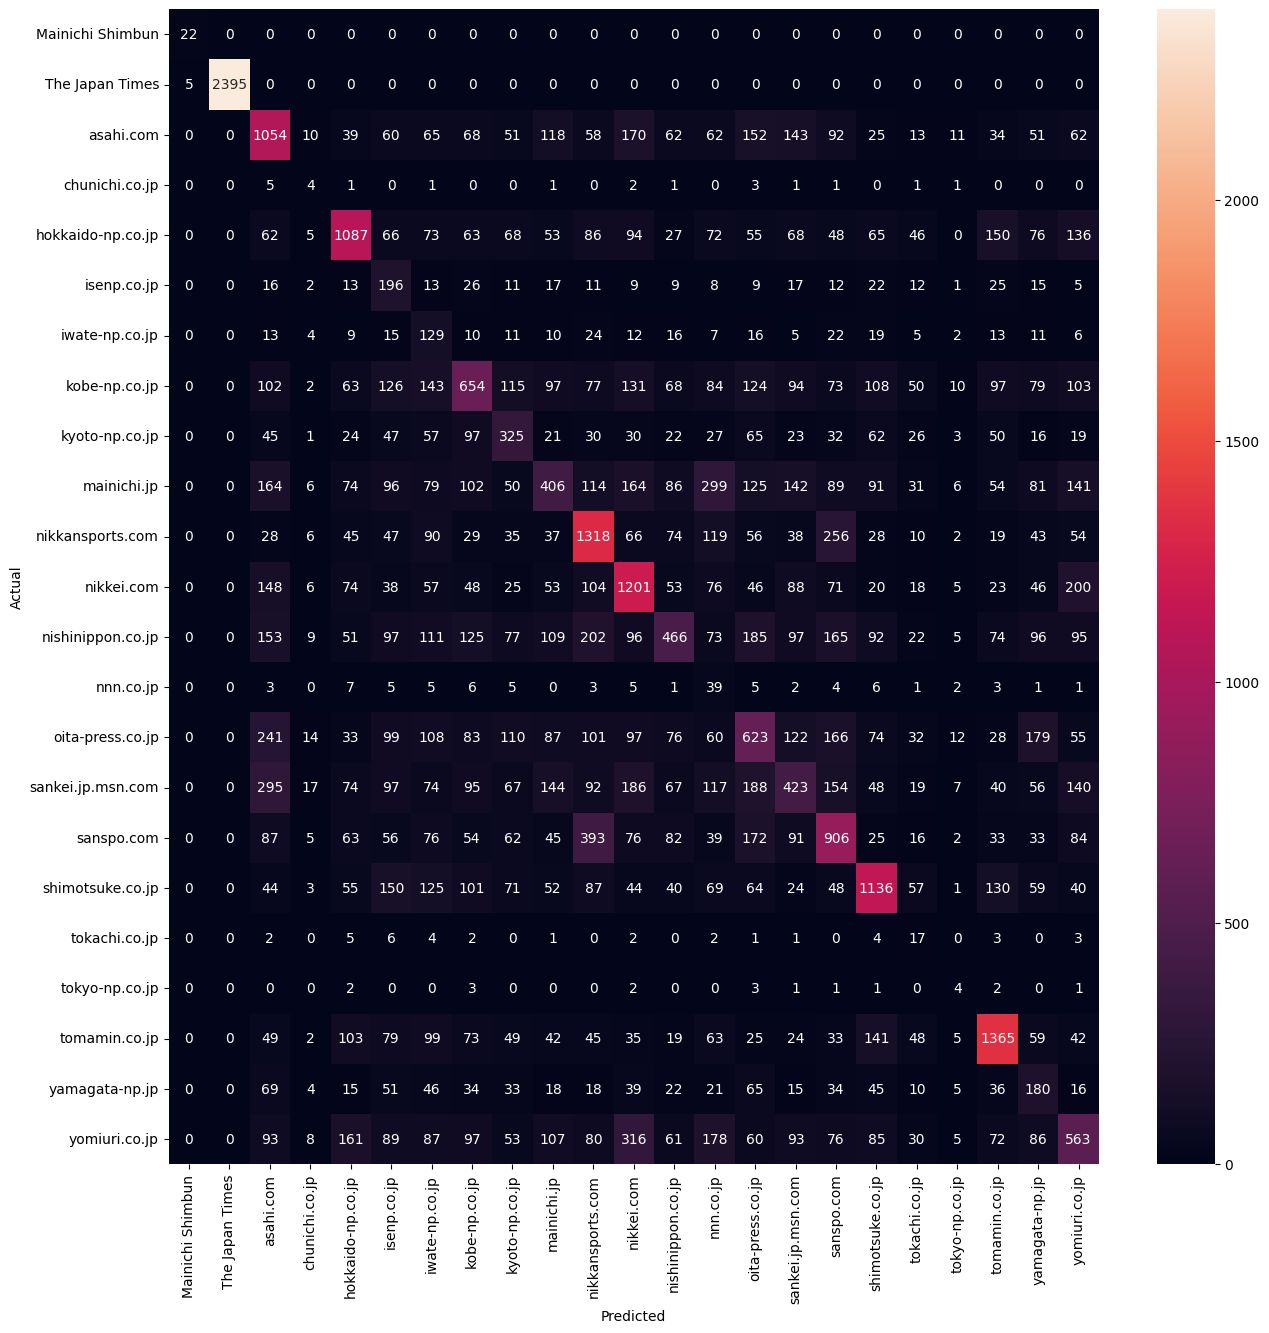

In [47]:
plot_confusion_matrix(X_test,y_test,y_pred)

In [49]:
print("TRAIN SET")
print(classification_report(y_sm,rfc.predict(X_sm),digits=4))
print("TEST SET")
print(classification_report(y_test,rfc.predict(X_test),digits=4))

TRAIN SET
                   precision    recall  f1-score   support

 Mainichi Shimbun     1.0000    1.0000    1.0000      5600
  The Japan Times     1.0000    1.0000    1.0000      5600
        asahi.com     0.9968    0.9866    0.9917      5600
   chunichi.co.jp     0.9993    1.0000    0.9996      5600
hokkaido-np.co.jp     0.9966    0.9848    0.9907      5600
      isenp.co.jp     0.9995    0.9982    0.9988      5600
   iwate-np.co.jp     0.9988    0.9989    0.9988      5600
    kobe-np.co.jp     0.9956    0.9741    0.9847      5600
   kyoto-np.co.jp     0.9991    0.9979    0.9985      5600
      mainichi.jp     0.8218    0.9877    0.8972      5600
 nikkansports.com     0.9898    0.9561    0.9727      5600
       nikkei.com     0.9905    0.9820    0.9862      5600
nishinippon.co.jp     0.9944    0.9818    0.9880      5600
        nnn.co.jp     0.9993    0.9884    0.9938      5600
 oita-press.co.jp     0.9943    0.9929    0.9936      5600
sankei.jp.msn.com     0.9960    0.9743    0.9

## 2) KERAS

In [50]:
X_train,X_test,y_train,y_test=train_test_split(df["text"], df["source"], test_size=0.30, stratify=df["source"], random_state=42)

### LSTM - NUM WORDS = 5000

In [64]:
pad_X_train, pad_X_test, y_one_hot_train, y_one_hot_test, vocab_size = keras_preprocessing(X_train,X_test,y_train,y_test,5000)

In [65]:
clear_session()
model_LSTM=Sequential()
model_LSTM.add(Embedding(vocab_size,64,input_length=100))
model_LSTM.add(Flatten())
model_LSTM.add(Dense(32,activation="relu"))
model_LSTM.add(Dropout(.5))
model_LSTM.add(Dense(23,activation="softmax"))
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           5962240   
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 32)                204832    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 23)                759       
                                                                 
Total params: 6,167,831
Trainable params: 6,167,831
Non-trainable params: 0
_________________________________________________________________


In [66]:
model_LSTM.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["Precision","Recall", "Accuracy"])
hist_LSTM=model_LSTM.fit(pad_X_train,y_one_hot_train,batch_size=64, verbose=1, validation_data=(pad_X_test,y_one_hot_test), epochs=6)

Epoch 1/6
1329/1329 [==============================] - 123s 91ms/step - loss: 2.3669 - precision: 0.8873 - recall: 0.0965 - Accuracy: 0.2572 - val_loss: 1.9585 - val_precision: 0.9019 - val_recall: 0.1611 - val_Accuracy: 0.3997
Epoch 2/6
1329/1329 [==============================] - 121s 91ms/step - loss: 1.9329 - precision: 0.8366 - recall: 0.1892 - Accuracy: 0.3999 - val_loss: 1.8035 - val_precision: 0.8955 - val_recall: 0.2089 - val_Accuracy: 0.4523
Epoch 3/6
1329/1329 [==============================] - 125s 94ms/step - loss: 1.7121 - precision: 0.8408 - recall: 0.2516 - Accuracy: 0.4659 - val_loss: 1.7530 - val_precision: 0.8559 - val_recall: 0.2548 - val_Accuracy: 0.4728
Epoch 4/6
1329/1329 [==============================] - 122s 92ms/step - loss: 1.5214 - precision: 0.8465 - recall: 0.3151 - Accuracy: 0.5211 - val_loss: 1.7316 - val_precision: 0.8431 - val_recall: 0.2850 - val_Accuracy: 0.4855
Epoch 5/6
1329/1329 [==============================] - 123s 93ms/step - loss: 1.3556 - p

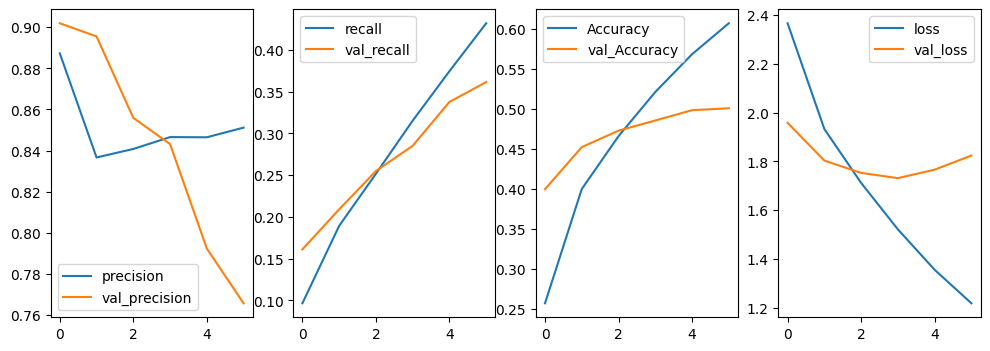

In [67]:
plot_metrics(hist_LSTM)

### LSTM - NUM WORDS = 10000

In [61]:
pad_X_train, pad_X_test, y_one_hot_train, y_one_hot_test, vocab_size = keras_preprocessing(X_train,X_test,y_train,y_test,10000)

In [62]:
clear_session()
model_LSTM2=Sequential()
model_LSTM2.add(Embedding(vocab_size,64,input_length=100))
model_LSTM2.add(Flatten())
model_LSTM2.add(Dense(32,activation="relu"))
model_LSTM2.add(Dropout(.5))
model_LSTM2.add(Dense(23,activation="softmax"))
model_LSTM2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           5953472   
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 32)                204832    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 23)                759       
                                                                 
Total params: 6,159,063
Trainable params: 6,159,063
Non-trainable params: 0
_________________________________________________________________


In [64]:
model_LSTM2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["Precision","Recall", "Accuracy"])
hist_LSTM2=model_LSTM2.fit(pad_X_train,y_one_hot_train,batch_size=64, verbose=1, validation_data=(pad_X_test,y_one_hot_test), epochs=6)

Epoch 1/6
1329/1329 [==============================] - 109s 81ms/step - loss: 2.3512 - precision: 0.8834 - recall: 0.0977 - Accuracy: 0.2611 - val_loss: 1.9242 - val_precision: 0.9267 - val_recall: 0.1659 - val_Accuracy: 0.4137
Epoch 2/6
1329/1329 [==============================] - 109s 82ms/step - loss: 1.8509 - precision: 0.8426 - recall: 0.2073 - Accuracy: 0.4261 - val_loss: 1.7335 - val_precision: 0.8813 - val_recall: 0.2414 - val_Accuracy: 0.4780
Epoch 3/6
1329/1329 [==============================] - 108s 81ms/step - loss: 1.5599 - precision: 0.8500 - recall: 0.3003 - Accuracy: 0.5146 - val_loss: 1.6689 - val_precision: 0.8289 - val_recall: 0.3133 - val_Accuracy: 0.5020
Epoch 4/6
1329/1329 [==============================] - 110s 83ms/step - loss: 1.3132 - precision: 0.8523 - recall: 0.3906 - Accuracy: 0.5851 - val_loss: 1.6792 - val_precision: 0.7986 - val_recall: 0.3603 - val_Accuracy: 0.5185
Epoch 5/6
1329/1329 [==============================] - 110s 83ms/step - loss: 1.1109 - p

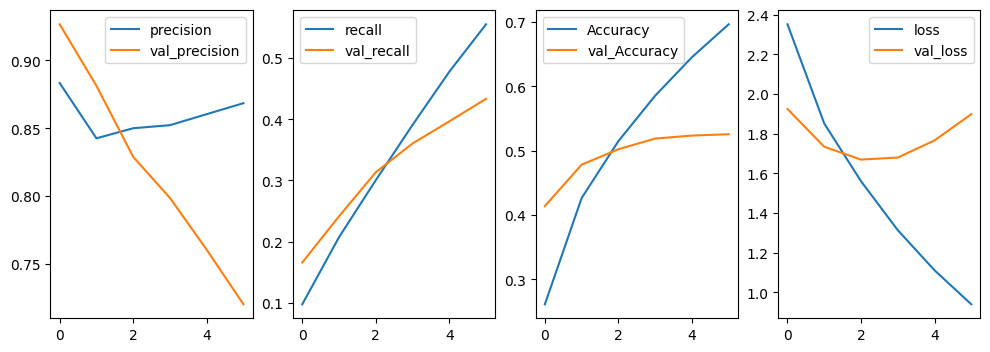

In [65]:
plot_metrics(hist_LSTM2)

### BILSTM - NUM WORDS = 10000

In [51]:
pad_X_train, pad_X_test, y_one_hot_train, y_one_hot_test, vocab_size = keras_preprocessing(X_train,X_test,y_train,y_test,10000)

In [52]:
clear_session()
model_biLSTM=Sequential()
model_biLSTM.add(Embedding(vocab_size,64,input_length=100))
model_biLSTM.add(Bidirectional(LSTM(32,return_sequences=True,activation="tanh",dropout=0.5)))
#model_biLSTM.add(TimeDistributed(Dense(32,activation="relu")))
model_biLSTM.add(Flatten())
model_biLSTM.add(Dense(32,activation="relu"))
model_biLSTM.add(Dropout(.5))
model_biLSTM.add(Dense(23,activation="softmax"))
model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           5953472   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 64)          24832     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 32)                204832    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 23)                759       
                                                        

In [53]:
model_biLSTM.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["Precision","Recall", "Accuracy"])
hist_biLSTM=model_biLSTM.fit(pad_X_train,y_one_hot_train,batch_size=64, verbose=1, validation_data=(pad_X_test,y_one_hot_test), epochs=6)

Epoch 1/6
1329/1329 [==============================] - 276s 204ms/step - loss: 2.3211 - precision: 0.8489 - recall: 0.1103 - Accuracy: 0.2706 - val_loss: 1.9192 - val_precision: 0.8948 - val_recall: 0.1789 - val_Accuracy: 0.4052
Epoch 2/6
1329/1329 [==============================] - 268s 202ms/step - loss: 1.9374 - precision: 0.8325 - recall: 0.2002 - Accuracy: 0.3953 - val_loss: 1.7862 - val_precision: 0.8614 - val_recall: 0.2445 - val_Accuracy: 0.4527
Epoch 3/6
1329/1329 [==============================] - 277s 209ms/step - loss: 1.7963 - precision: 0.8325 - recall: 0.2464 - Accuracy: 0.4413 - val_loss: 1.7336 - val_precision: 0.8441 - val_recall: 0.2802 - val_Accuracy: 0.4720
Epoch 4/6
1329/1329 [==============================] - 278s 209ms/step - loss: 1.7103 - precision: 0.8386 - recall: 0.2745 - Accuracy: 0.4681 - val_loss: 1.6984 - val_precision: 0.8340 - val_recall: 0.2948 - val_Accuracy: 0.4847
Epoch 5/6
1329/1329 [==============================] - 277s 209ms/step - loss: 1.640

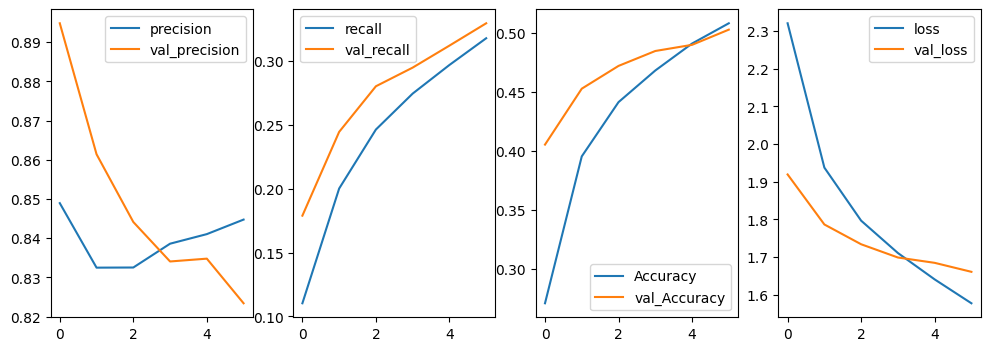

In [54]:
plot_metrics(hist_biLSTM)

### LSTM - BOOSTED HYPERPARAMETERS
(lower batch size, higher n. of epochs, added layers) ** NOT TESTED FOR TIME REASONS **

In [ ]:
pad_X_train, pad_X_test, y_one_hot_train, y_one_hot_test, vocab_size = keras_preprocessing(X_train,X_test,y_train,y_test,10000)

In [ ]:
clear_session()
model_LSTM_boost=Sequential()
model_LSTM_boost.add(Embedding(vocab_size,128,input_length=100))
model_LSTM_boost.add(Dense(64,activation="relu"))
model_LSTM_boost.add(Flatten())
model_LSTM_boost.add(Dense(32,activation="relu"))
model_LSTM_boost.add(Dropout(.5))
model_LSTM_boost.add(Dense(23,activation="softmax"))
model_LSTM_boost.summary()

In [ ]:
model_LSTM_boost.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["Precision","Recall", "Accuracy"])
hist_LSTM_boost=model_LSTM_boost.fit(pad_X_train,y_one_hot_train,batch_size=64, verbose=1, validation_data=(pad_X_test,y_one_hot_test), epochs=6)

In [ ]:
plot_metrics(model_LSTM_boost)

### BILSTM - BOOSTED HYPERPARAMETERS
(lower batch size, higher n. of epochs, added layers)
** NOT TESTED FOR TIME REASONS **

In [55]:
pad_X_train, pad_X_test, y_one_hot_train, y_one_hot_test, vocab_size = keras_preprocessing(X_train,X_test,y_train,y_test,10000)

In [56]:
clear_session()
model_biLSTM=Sequential()
model_biLSTM.add(Embedding(vocab_size,128,input_length=100))
model_biLSTM.add(Bidirectional(LSTM(64,return_sequences=True,activation="tanh",dropout=0.5)))
model_biLSTM.add(TimeDistributed(Dense(32,activation="relu")))
model_biLSTM.add(Flatten())
model_biLSTM.add(Dense(32,activation="relu"))
model_biLSTM.add(Dropout(.5))
model_biLSTM.add(Dense(23,activation="softmax"))
model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          11906944  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         98816     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 32)          4128      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                102432    
                                                                 
 dropout (Dropout)           (None, 32)                0

In [ ]:
model_biLSTM.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["Precision","Recall", "Accuracy"])
hist_biLSTM=model_biLSTM.fit(pad_X_train,y_one_hot_train,batch_size=32, verbose=1, validation_data=(pad_X_test,y_one_hot_test), epochs=20)

## NOTES

Next analysis/improvement may be:



1.   improving the RNN (trying GRU, simple_RNN, a TimeDistributed Layer, adding some Dense layers, changing hyperparameters, increasing number of epochs, etc...)
2.   balancing the dataframe before RNN models, oversampling minority classes
3. testing different hyperparameters of SKLEARN models
4. Trying oversampling & undersampling methods different from SMOTE
5. Running without RAM limitations the SKLEARN models boosting dataframe dimension
6. creating a function with a parameter thrpugh which all models are callable and saving results to plot metrics comparisons



